# Using a GAN to Generate Stress-strain Curves

## Problem Definition

Assuming bi-linear stress strain behavior of a material (characterized by $\sigma_y$, $E$, and $H$), generate sample stress-strain curves based on some initial samples of a stress-strain curve distrbution. 

<img src="bilinear.png" alt="Drawing" style="width: 300px;"/>

## Generating the training data

The training samples will be gathered by asuming independent, normal distributions for $\sigma_y$, $E$, and $H$.

  * $\sigma_y \sim \mathcal{N}(\mu=10, \sigma=0.5)$
  * $E \sim \mathcal{N}(\mu=1000, \sigma=50)$
  * $H \sim \mathcal{N}(\mu=50, \sigma=5)$

In [1]:
import numpy as np
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import pandas as pd

Two helper functions

In [2]:
def get_stress(strains, E, s_y, H):
    e_y = s_y / E
    elastic_strains = strains.copy()
    elastic_strains[elastic_strains > e_y] = e_y
    plastic_strains = strains - elastic_strains
    stresses = elastic_strains*E + plastic_strains*H
    return stresses

In [3]:
def generate_samples(max_strain, n_strain, n_samples):
    strain = np.linspace(0, max_strain, n_strain + 1)[1:]
    stresses = np.empty((n_samples, n_strain))
    for i in range(n_samples):
        E = np.random.normal(1000, 50)
        s_y = np.random.normal(10, 0.5)
        H = np.random.normal(50, 5)
        stresses[i] = get_stress(strain, E, s_y, H)
    return stresses, strain

Make training data:

  * rows in stress_mat correspond to the stresses in a single stress strain curve (i.e. 1 sample)
  * columns in stress_mat correspond to a single strain value

In [4]:
N_SAMPLES = 100000
MAX_STRAIN = 0.02
NUM_STRAINS = 10

stress_mat, strains = generate_samples(MAX_STRAIN, NUM_STRAINS, N_SAMPLES)

Visualize the training distribution

In [5]:
from ipywidgets import interact
import ipywidgets as widgets

def plot_hist(x):
    fig, (ax_left, ax_right) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]},
                                       figsize=(16, 7))
    
    sns.violinplot(data=pd.DataFrame(data=stress_mat, columns=np.round(strains, 3)), 
                   ax=ax_left)
    ax_left.set(xlabel='strain', ylabel='stress')
    
    itemindex = np.argmin(abs(strains-x))
    sns.distplot(stress_mat[:, itemindex], bins=20)
    ax_right.set(xlim=(np.min(stress_mat), np.max(stress_mat)),
                 xlabel='stresses at strain of %.3f' % strains[itemindex])
    
interact(plot_hist, x=(0.0, 0.02, 0.002))

interactive(children=(FloatSlider(value=0.01, description='x', max=0.02, step=0.002), Output()), _dom_classes=…

<function __main__.plot_hist(x)>

## Train a GAN to produce samples that match this distribution

In [6]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Settings

In [7]:
EPOCHS = 10
N_SAMPLES = 2560000
BATCH_SIZE = 256
ITERATIONS = int(N_SAMPLES/BATCH_SIZE)
TRAIN_STEPS = 10
NOISE_DIM = 20

### 1. Prepare dataset

* #### Normalize and shuffle data

In [8]:
def standardize(data):
    scaler = StandardScaler()
    scaler.fit(data)
    standardized_data = scaler.transform(data)
    
    return standardized_data, scaler

In [9]:
def normalize(data):
    scaler = MinMaxScaler()
    scaler.fit(data)
    normalized_data = scaler.transform(data)
    
    return normalized_data, scaler

In [13]:
def generate_batch(batch_size, preprocessing):
    stresses, strain = generate_samples(MAX_STRAIN, NUM_STRAINS, batch_size)
    batch = []
    
    for curve in stresses:
        curve = np.concatenate((np.expand_dims(np.array(strains), -1), np.expand_dims(curve, -1)), axis=1)
        preprocessed_curve, scaler = preprocessing(curve)
        batch.append(preprocessed_curve)
            
    return np.array(batch), scaler

In [14]:
dataset = []

for i in tqdm(range(ITERATIONS)):
    standardized_sample, scaler = generate_batch(BATCH_SIZE, standardize)
    dataset.append(standardized_sample)

dataset = np.array(dataset)

100%|██████████| 10000/10000 [11:28<00:00, 14.84it/s]


### 2. Create Models

* #### Generator

In [15]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(10,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(32, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(20, use_bias=False))
    model.add(layers.Reshape((10,2)))
    return model

In [16]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                640       
_________________________________________________________________
batch_normalization_v2 (Batc (None, 32)                128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1024      
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 32)                128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0

* #### Discriminator

In [17]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(10,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(32))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(32))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(20))
    model.add(layers.Dense(1))
    
    return model

In [18]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                672       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)               

### 3. Define loss and optimizers

In [19]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

* #### Discriminator loss

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

* #### Generator loss

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

* #### Optimizers

In [22]:
generator_optimizer = tf.keras.optimizers.RMSprop(1e-3)
discriminator_optimizer = tf.keras.optimizers.RMSprop(1e-3)

* #### Save checkpoints

In [23]:
checkpoint_dir = './v3_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 4. Training

In [24]:
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch, noise):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_batch = generator(noise, training=True)

        real_output = discriminator(batch, training=True)
        fake_output = discriminator(generated_batch, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return disc_loss, gen_loss

In [25]:
def train(epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for i in tqdm(range(ITERATIONS)):
            iter_start = time.time()
            
            sample_batch = dataset[i]
            np.random.shuffle(sample_batch)
            noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

            for step in range(TRAIN_STEPS):
                disc_loss, gen_loss = train_step(sample_batch, noise)

            if (i + 1) % 1000 == 0:
                print('Time for iteration {} is {} sec'.format(i + 1, time.time()-iter_start))
                print("Discriminator loss: {0:.4f}\t Generator loss: {0:.4f}\n".format(disc_loss.numpy(), gen_loss.numpy()))

        # Save the model every 15 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print("Discriminator loss: {0:.4f}\t Generator loss: {0:.4f}\n".format(disc_loss.numpy(), gen_loss.numpy()))

In [26]:
%%time
train(EPOCHS)

 10%|█         | 1012/10000 [00:15<01:49, 82.33it/s]

Time for iteration 1000 is 0.011893987655639648 sec
Discriminator loss: 0.8217	 Generator loss: 0.8217



 20%|██        | 2011/10000 [00:27<01:36, 82.95it/s]

Time for iteration 2000 is 0.011176109313964844 sec
Discriminator loss: 0.6152	 Generator loss: 0.6152



 30%|███       | 3010/10000 [00:39<01:24, 82.41it/s]

Time for iteration 3000 is 0.012073755264282227 sec
Discriminator loss: 0.5924	 Generator loss: 0.5924



 40%|████      | 4009/10000 [00:52<01:12, 82.94it/s]

Time for iteration 4000 is 0.011708736419677734 sec
Discriminator loss: 0.9483	 Generator loss: 0.9483



 50%|█████     | 5008/10000 [01:04<01:01, 81.74it/s]

Time for iteration 5000 is 0.012375354766845703 sec
Discriminator loss: 0.3241	 Generator loss: 0.3241



 60%|██████    | 6016/10000 [01:16<00:47, 83.02it/s]

Time for iteration 6000 is 0.011698246002197266 sec
Discriminator loss: 0.6803	 Generator loss: 0.6803



 70%|███████   | 7015/10000 [01:28<00:35, 83.08it/s]

Time for iteration 7000 is 0.011858463287353516 sec
Discriminator loss: 0.7118	 Generator loss: 0.7118



 80%|████████  | 8014/10000 [01:40<00:23, 83.77it/s]

Time for iteration 8000 is 0.011668920516967773 sec
Discriminator loss: 0.2907	 Generator loss: 0.2907



 90%|█████████ | 9013/10000 [01:52<00:12, 82.24it/s]

Time for iteration 9000 is 0.01185154914855957 sec
Discriminator loss: 0.2135	 Generator loss: 0.2135



  0%|          | 9/10000 [00:00<02:01, 82.46it/s]

Time for iteration 10000 is 0.011899709701538086 sec
Discriminator loss: 0.6612	 Generator loss: 0.6612

Time for epoch 1 is 124.94568514823914 sec
Discriminator loss: 0.6612	 Generator loss: 0.6612



 10%|█         | 1016/10000 [00:12<01:49, 82.08it/s]

Time for iteration 1000 is 0.012036800384521484 sec
Discriminator loss: 0.2385	 Generator loss: 0.2385



 20%|██        | 2015/10000 [00:24<01:36, 83.06it/s]

Time for iteration 2000 is 0.01230931282043457 sec
Discriminator loss: 0.1880	 Generator loss: 0.1880



 30%|███       | 3014/10000 [00:36<01:25, 81.97it/s]

Time for iteration 3000 is 0.013438940048217773 sec
Discriminator loss: 0.4135	 Generator loss: 0.4135



 40%|████      | 4013/10000 [00:48<01:12, 82.94it/s]

Time for iteration 4000 is 0.012255668640136719 sec
Discriminator loss: 0.3656	 Generator loss: 0.3656



 50%|█████     | 5012/10000 [01:00<01:00, 82.96it/s]

Time for iteration 5000 is 0.01151418685913086 sec
Discriminator loss: 0.7347	 Generator loss: 0.7347



 60%|██████    | 6011/10000 [01:12<00:47, 83.23it/s]

Time for iteration 6000 is 0.012392759323120117 sec
Discriminator loss: 0.3185	 Generator loss: 0.3185



 70%|███████   | 7010/10000 [01:25<00:36, 82.69it/s]

Time for iteration 7000 is 0.012156009674072266 sec
Discriminator loss: 0.5384	 Generator loss: 0.5384



 80%|████████  | 8009/10000 [01:37<00:24, 82.90it/s]

Time for iteration 8000 is 0.012403726577758789 sec
Discriminator loss: 0.2246	 Generator loss: 0.2246



 90%|█████████ | 9008/10000 [01:49<00:12, 82.10it/s]

Time for iteration 9000 is 0.012613296508789062 sec
Discriminator loss: 0.3474	 Generator loss: 0.3474



  0%|          | 9/10000 [00:00<02:03, 80.95it/s]

Time for iteration 10000 is 0.012633085250854492 sec
Discriminator loss: 0.4253	 Generator loss: 0.4253

Time for epoch 2 is 121.30765891075134 sec
Discriminator loss: 0.4253	 Generator loss: 0.4253



 10%|█         | 1016/10000 [00:12<01:50, 81.51it/s]

Time for iteration 1000 is 0.011867046356201172 sec
Discriminator loss: 0.4135	 Generator loss: 0.4135



 20%|██        | 2015/10000 [00:24<01:36, 82.48it/s]

Time for iteration 2000 is 0.011737585067749023 sec
Discriminator loss: 0.4901	 Generator loss: 0.4901



 30%|███       | 3014/10000 [00:36<01:24, 82.72it/s]

Time for iteration 3000 is 0.011821746826171875 sec
Discriminator loss: 0.4507	 Generator loss: 0.4507



 40%|████      | 4013/10000 [00:48<01:12, 82.16it/s]

Time for iteration 4000 is 0.011688709259033203 sec
Discriminator loss: 0.2929	 Generator loss: 0.2929



 50%|█████     | 5012/10000 [01:00<01:01, 81.54it/s]

Time for iteration 5000 is 0.012151718139648438 sec
Discriminator loss: 0.2811	 Generator loss: 0.2811



 60%|██████    | 6011/10000 [01:12<00:48, 81.48it/s]

Time for iteration 6000 is 0.011969327926635742 sec
Discriminator loss: 1.8642	 Generator loss: 1.8642



 70%|███████   | 7010/10000 [01:25<00:36, 82.67it/s]

Time for iteration 7000 is 0.012036323547363281 sec
Discriminator loss: 0.1978	 Generator loss: 0.1978



 80%|████████  | 8008/10000 [01:37<00:26, 76.14it/s]

Time for iteration 8000 is 0.012639760971069336 sec
Discriminator loss: 0.0895	 Generator loss: 0.0895



 90%|█████████ | 9016/10000 [01:49<00:11, 82.68it/s]

Time for iteration 9000 is 0.01242971420288086 sec
Discriminator loss: 0.2041	 Generator loss: 0.2041



  0%|          | 9/10000 [00:00<02:02, 81.84it/s]

Time for iteration 10000 is 0.01226043701171875 sec
Discriminator loss: 0.4664	 Generator loss: 0.4664

Time for epoch 3 is 121.68046736717224 sec
Discriminator loss: 0.4664	 Generator loss: 0.4664



 10%|█         | 1013/10000 [00:12<01:50, 81.66it/s]

Time for iteration 1000 is 0.012032032012939453 sec
Discriminator loss: 0.2269	 Generator loss: 0.2269



 20%|██        | 2012/10000 [00:24<01:36, 82.65it/s]

Time for iteration 2000 is 0.01165008544921875 sec
Discriminator loss: 0.2924	 Generator loss: 0.2924



 30%|███       | 3011/10000 [00:36<01:25, 82.16it/s]

Time for iteration 3000 is 0.012015581130981445 sec
Discriminator loss: 0.2965	 Generator loss: 0.2965



 40%|████      | 4010/10000 [00:48<01:12, 82.99it/s]

Time for iteration 4000 is 0.01187896728515625 sec
Discriminator loss: 3.8692	 Generator loss: 3.8692



 50%|█████     | 5009/10000 [01:00<01:00, 83.14it/s]

Time for iteration 5000 is 0.011686086654663086 sec
Discriminator loss: 0.2458	 Generator loss: 0.2458



 60%|██████    | 6008/10000 [01:13<00:48, 82.48it/s]

Time for iteration 6000 is 0.012744903564453125 sec
Discriminator loss: 0.1579	 Generator loss: 0.1579



 70%|███████   | 7016/10000 [01:25<00:35, 82.95it/s]

Time for iteration 7000 is 0.012212991714477539 sec
Discriminator loss: 0.5993	 Generator loss: 0.5993



 80%|████████  | 8015/10000 [01:37<00:24, 82.11it/s]

Time for iteration 8000 is 0.011350870132446289 sec
Discriminator loss: 0.1626	 Generator loss: 0.1626



 90%|█████████ | 9014/10000 [01:49<00:12, 81.70it/s]

Time for iteration 9000 is 0.011897802352905273 sec
Discriminator loss: 0.3562	 Generator loss: 0.3562



  0%|          | 9/10000 [00:00<02:02, 81.31it/s]

Time for iteration 10000 is 0.012502431869506836 sec
Discriminator loss: 0.2868	 Generator loss: 0.2868

Time for epoch 4 is 121.5257613658905 sec
Discriminator loss: 0.2868	 Generator loss: 0.2868



 10%|█         | 1009/10000 [00:12<01:47, 83.51it/s]

Time for iteration 1000 is 0.011540651321411133 sec
Discriminator loss: 0.3837	 Generator loss: 0.3837



 20%|██        | 2008/10000 [00:24<01:35, 83.64it/s]

Time for iteration 2000 is 0.01161956787109375 sec
Discriminator loss: 1.2792	 Generator loss: 1.2792



 30%|███       | 3016/10000 [00:36<01:22, 84.30it/s]

Time for iteration 3000 is 0.011573314666748047 sec
Discriminator loss: 0.3616	 Generator loss: 0.3616



 40%|████      | 4015/10000 [00:48<01:12, 82.11it/s]

Time for iteration 4000 is 0.011854410171508789 sec
Discriminator loss: 0.2017	 Generator loss: 0.2017



 50%|█████     | 5014/10000 [01:00<00:59, 83.16it/s]

Time for iteration 5000 is 0.012046337127685547 sec
Discriminator loss: 0.2437	 Generator loss: 0.2437



 60%|██████    | 6013/10000 [01:12<00:48, 82.58it/s]

Time for iteration 6000 is 0.011802911758422852 sec
Discriminator loss: 0.3731	 Generator loss: 0.3731



 70%|███████   | 7012/10000 [01:24<00:36, 82.19it/s]

Time for iteration 7000 is 0.012338399887084961 sec
Discriminator loss: 0.4652	 Generator loss: 0.4652



 80%|████████  | 8011/10000 [01:36<00:24, 81.71it/s]

Time for iteration 8000 is 0.012411117553710938 sec
Discriminator loss: 0.0815	 Generator loss: 0.0815



 90%|█████████ | 9010/10000 [01:48<00:12, 81.36it/s]

Time for iteration 9000 is 0.01217198371887207 sec
Discriminator loss: 0.1861	 Generator loss: 0.1861



  0%|          | 9/10000 [00:00<02:00, 82.76it/s]

Time for iteration 10000 is 0.01190805435180664 sec
Discriminator loss: 0.3305	 Generator loss: 0.3305

Time for epoch 5 is 120.91113424301147 sec
Discriminator loss: 0.3305	 Generator loss: 0.3305



 10%|█         | 1016/10000 [00:12<01:48, 83.14it/s]

Time for iteration 1000 is 0.011584281921386719 sec
Discriminator loss: 0.3061	 Generator loss: 0.3061



 20%|██        | 2015/10000 [00:24<01:36, 82.76it/s]

Time for iteration 2000 is 0.01144266128540039 sec
Discriminator loss: 0.2824	 Generator loss: 0.2824



 30%|███       | 3015/10000 [00:36<01:24, 82.26it/s]

Time for iteration 3000 is 0.011911392211914062 sec
Discriminator loss: 0.3068	 Generator loss: 0.3068



 40%|████      | 4014/10000 [00:48<01:12, 82.66it/s]

Time for iteration 4000 is 0.012084722518920898 sec
Discriminator loss: 0.1520	 Generator loss: 0.1520



 50%|█████     | 5013/10000 [01:00<00:59, 83.39it/s]

Time for iteration 5000 is 0.011625528335571289 sec
Discriminator loss: 0.1519	 Generator loss: 0.1519



 60%|██████    | 6012/10000 [01:12<00:48, 81.81it/s]

Time for iteration 6000 is 0.011852025985717773 sec
Discriminator loss: 0.1075	 Generator loss: 0.1075



 70%|███████   | 7011/10000 [01:25<00:36, 81.47it/s]

Time for iteration 7000 is 0.01184844970703125 sec
Discriminator loss: 0.2584	 Generator loss: 0.2584



 80%|████████  | 8010/10000 [01:37<00:24, 81.96it/s]

Time for iteration 8000 is 0.011642694473266602 sec
Discriminator loss: 0.1870	 Generator loss: 0.1870



 90%|█████████ | 9009/10000 [01:49<00:11, 83.30it/s]

Time for iteration 9000 is 0.011963129043579102 sec
Discriminator loss: 0.3167	 Generator loss: 0.3167



  0%|          | 9/10000 [00:00<01:58, 84.64it/s]

Time for iteration 10000 is 0.012797117233276367 sec
Discriminator loss: 0.3351	 Generator loss: 0.3351

Time for epoch 6 is 121.2908673286438 sec
Discriminator loss: 0.3351	 Generator loss: 0.3351



 10%|█         | 1010/10000 [00:12<01:46, 84.51it/s]

Time for iteration 1000 is 0.011848211288452148 sec
Discriminator loss: 0.2708	 Generator loss: 0.2708



 20%|██        | 2013/10000 [00:23<01:32, 86.05it/s]

Time for iteration 2000 is 0.011142969131469727 sec
Discriminator loss: 0.2315	 Generator loss: 0.2315



 30%|███       | 3017/10000 [00:35<01:22, 84.92it/s]

Time for iteration 3000 is 0.012159585952758789 sec
Discriminator loss: 0.2496	 Generator loss: 0.2496



 40%|████      | 4010/10000 [00:47<01:13, 81.84it/s]

Time for iteration 4000 is 0.012305736541748047 sec
Discriminator loss: 0.3312	 Generator loss: 0.3312



 50%|█████     | 5009/10000 [00:59<01:01, 81.72it/s]

Time for iteration 5000 is 0.012293100357055664 sec
Discriminator loss: 0.3271	 Generator loss: 0.3271



 60%|██████    | 6008/10000 [01:11<00:48, 82.57it/s]

Time for iteration 6000 is 0.013139963150024414 sec
Discriminator loss: 0.2502	 Generator loss: 0.2502



 70%|███████   | 7016/10000 [01:23<00:36, 82.60it/s]

Time for iteration 7000 is 0.011978387832641602 sec
Discriminator loss: 0.1763	 Generator loss: 0.1763



 80%|████████  | 8015/10000 [01:36<00:23, 83.55it/s]

Time for iteration 8000 is 0.011965513229370117 sec
Discriminator loss: 0.3837	 Generator loss: 0.3837



 90%|█████████ | 9014/10000 [01:48<00:11, 82.64it/s]

Time for iteration 9000 is 0.01154780387878418 sec
Discriminator loss: 0.2444	 Generator loss: 0.2444



  0%|          | 9/10000 [00:00<02:02, 81.58it/s]

Time for iteration 10000 is 0.012148380279541016 sec
Discriminator loss: 0.2449	 Generator loss: 0.2449

Time for epoch 7 is 120.15855956077576 sec
Discriminator loss: 0.2449	 Generator loss: 0.2449



 10%|█         | 1014/10000 [00:12<01:50, 81.65it/s]

Time for iteration 1000 is 0.011853933334350586 sec
Discriminator loss: 0.2656	 Generator loss: 0.2656



 20%|██        | 2013/10000 [00:24<01:38, 81.26it/s]

Time for iteration 2000 is 0.012272357940673828 sec
Discriminator loss: 0.2467	 Generator loss: 0.2467



 30%|███       | 3012/10000 [00:36<01:25, 81.49it/s]

Time for iteration 3000 is 0.011997699737548828 sec
Discriminator loss: 0.4132	 Generator loss: 0.4132



 40%|████      | 4011/10000 [00:48<01:12, 82.51it/s]

Time for iteration 4000 is 0.012598514556884766 sec
Discriminator loss: 0.2536	 Generator loss: 0.2536



 50%|█████     | 5010/10000 [01:00<01:00, 82.70it/s]

Time for iteration 5000 is 0.012176036834716797 sec
Discriminator loss: 0.3994	 Generator loss: 0.3994



 60%|██████    | 6009/10000 [01:13<00:48, 82.31it/s]

Time for iteration 6000 is 0.012096166610717773 sec
Discriminator loss: 0.3524	 Generator loss: 0.3524



 70%|███████   | 7008/10000 [01:25<00:36, 81.98it/s]

Time for iteration 7000 is 0.01315760612487793 sec
Discriminator loss: 0.2807	 Generator loss: 0.2807



 80%|████████  | 8016/10000 [01:37<00:24, 82.37it/s]

Time for iteration 8000 is 0.012112855911254883 sec
Discriminator loss: 0.1550	 Generator loss: 0.1550



 90%|█████████ | 9015/10000 [01:49<00:12, 81.98it/s]

Time for iteration 9000 is 0.011806726455688477 sec
Discriminator loss: 0.3829	 Generator loss: 0.3829



  0%|          | 9/10000 [00:00<02:02, 81.58it/s]

Time for iteration 10000 is 0.012166976928710938 sec
Discriminator loss: 0.4041	 Generator loss: 0.4041

Time for epoch 8 is 121.45300698280334 sec
Discriminator loss: 0.4041	 Generator loss: 0.4041



 10%|█         | 1016/10000 [00:12<01:48, 82.75it/s]

Time for iteration 1000 is 0.012624263763427734 sec
Discriminator loss: 0.0833	 Generator loss: 0.0833



 20%|██        | 2015/10000 [00:24<01:36, 82.72it/s]

Time for iteration 2000 is 0.011631250381469727 sec
Discriminator loss: 0.3286	 Generator loss: 0.3286



 30%|███       | 3014/10000 [00:36<01:24, 82.98it/s]

Time for iteration 3000 is 0.011698007583618164 sec
Discriminator loss: 0.1973	 Generator loss: 0.1973



 40%|████      | 4013/10000 [00:48<01:12, 82.35it/s]

Time for iteration 4000 is 0.012028694152832031 sec
Discriminator loss: 0.1874	 Generator loss: 0.1874



 50%|█████     | 5012/10000 [01:00<01:00, 81.91it/s]

Time for iteration 5000 is 0.012339353561401367 sec
Discriminator loss: 0.3597	 Generator loss: 0.3597



 60%|██████    | 6011/10000 [01:12<00:48, 81.44it/s]

Time for iteration 6000 is 0.012075424194335938 sec
Discriminator loss: 0.1854	 Generator loss: 0.1854



 70%|███████   | 7010/10000 [01:25<00:36, 82.05it/s]

Time for iteration 7000 is 0.012192964553833008 sec
Discriminator loss: 0.1975	 Generator loss: 0.1975



 80%|████████  | 8009/10000 [01:37<00:24, 81.75it/s]

Time for iteration 8000 is 0.012787580490112305 sec
Discriminator loss: 0.1568	 Generator loss: 0.1568



 90%|█████████ | 9009/10000 [01:49<00:12, 81.60it/s]

Time for iteration 9000 is 0.011774301528930664 sec
Discriminator loss: 0.1319	 Generator loss: 0.1319



  0%|          | 9/10000 [00:00<02:00, 83.24it/s]

Time for iteration 10000 is 0.012483835220336914 sec
Discriminator loss: 0.2693	 Generator loss: 0.2693

Time for epoch 9 is 121.43743371963501 sec
Discriminator loss: 0.2693	 Generator loss: 0.2693



 10%|█         | 1008/10000 [00:12<01:48, 82.88it/s]

Time for iteration 1000 is 0.013163089752197266 sec
Discriminator loss: 0.3206	 Generator loss: 0.3206



 20%|██        | 2016/10000 [00:24<01:37, 82.10it/s]

Time for iteration 2000 is 0.01229095458984375 sec
Discriminator loss: 0.0970	 Generator loss: 0.0970



 30%|███       | 3015/10000 [00:36<01:24, 82.70it/s]

Time for iteration 3000 is 0.012160062789916992 sec
Discriminator loss: 0.1320	 Generator loss: 0.1320



 40%|████      | 4014/10000 [00:48<01:12, 82.42it/s]

Time for iteration 4000 is 0.012124300003051758 sec
Discriminator loss: 0.2842	 Generator loss: 0.2842



 50%|█████     | 5013/10000 [01:00<01:00, 82.33it/s]

Time for iteration 5000 is 0.011945962905883789 sec
Discriminator loss: 0.3160	 Generator loss: 0.3160



 60%|██████    | 6013/10000 [01:12<00:47, 83.09it/s]

Time for iteration 6000 is 0.011754035949707031 sec
Discriminator loss: 0.0623	 Generator loss: 0.0623



 70%|███████   | 7012/10000 [01:25<00:36, 82.78it/s]

Time for iteration 7000 is 0.011873483657836914 sec
Discriminator loss: 0.2069	 Generator loss: 0.2069



 80%|████████  | 8011/10000 [01:37<00:24, 81.95it/s]

Time for iteration 8000 is 0.012295961380004883 sec
Discriminator loss: 0.2484	 Generator loss: 0.2484



 90%|█████████ | 9010/10000 [01:49<00:12, 81.66it/s]

Time for iteration 9000 is 0.011978864669799805 sec
Discriminator loss: 0.2970	 Generator loss: 0.2970



100%|██████████| 10000/10000 [02:01<00:00, 82.37it/s]

Time for iteration 10000 is 0.011790990829467773 sec
Discriminator loss: 0.2826	 Generator loss: 0.2826

Time for epoch 10 is 121.44710683822632 sec
Discriminator loss: 0.2826	 Generator loss: 0.2826

CPU times: user 1h 7min 22s, sys: 9min 21s, total: 1h 16min 43s
Wall time: 20min 16s


In [27]:
def plot_examples(real, generated):
    r_ax = plt.scatter(real[:,:,0], real[:,:,1], label='Real Data')
    g_ax = plt.scatter(generated[:,:,0], generated[:,:,1], label='Generated Data', color='orange')
    plt.legend()
    plt.title('Samples')
    plt.tight_layout()

(256, 10, 2)
(256, 10, 2)


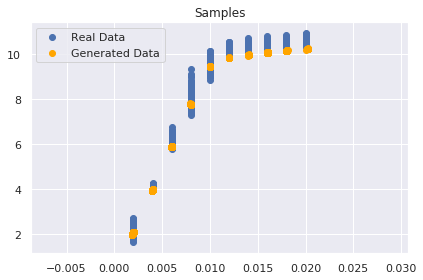

In [29]:
num_examples = 256
seed = tf.random.normal([num_examples, NOISE_DIM])
#seed = tf.random.uniform(minval= -1., maxval= 1., shape=[BATCH_SIZE, NOISE_DIM])

pred = generator(seed, training=False)
unscaled_pred = scaler.inverse_transform(pred)

samples, scaler = generate_batch(batch_size=num_examples, preprocessing=standardize)
unscaled_samples = scaler.inverse_transform(samples)

print(unscaled_samples.shape)
print(unscaled_pred.shape)

plot_examples(unscaled_samples, unscaled_pred)

In [30]:
print(np.min(unscaled_pred[:,:,1]))
print(unscaled_pred[:,:].shape)
print(np.max(stress_mat))

1.9772013
(256, 10, 2)
12.492057964542855


In [31]:
def plot_hist_results(x):
    fig, (ax_left, ax_right) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]},
                                       figsize=(16, 7))
    
    sns.violinplot(data=pd.DataFrame(data=unscaled_pred[:,:,1], columns=np.round(strains, 3)), 
                   ax=ax_left)
    ax_left.set(xlabel='strain', ylabel='stress')
    
    itemindex = np.argmin(abs(strains-x))
    sns.distplot(unscaled_pred[:, itemindex, 1], bins=20)
    ax_right.set(xlim=(np.min(unscaled_pred[:,:,1]), np.max(unscaled_pred[:,:,1])),
                 xlabel='stresses at strain of %.3f' % strains[itemindex])
    
interact(plot_hist_results, x=(0.0, 0.02, 0.002))

interactive(children=(FloatSlider(value=0.01, description='x', max=0.02, step=0.002), Output()), _dom_classes=…

<function __main__.plot_hist_results(x)>